In [12]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import gymnasium as gym
import highway_env
from gymnasium.wrappers import TimeLimit

def make_env():
    env = gym.make("highway-v0", render_mode=None)
    env = env.unwrapped  
    env.configure({
        "vehicles_count": 5,
        "duration": 40,
        "simulation_frequency": 15,
        "policy_frequency": 5,
        "observation": {
            "type": "Kinematics",
            "vehicles_count": 5,
            "features": ["presence", "x", "y", "vx", "vy"],
            "normalize": True,
        },
        "action": {
            "type": "DiscreteMetaAction"
        },
        "lanes_count": 3,
    })
    return TimeLimit(env, max_episode_steps=40)



In [13]:
def shaped_reward(env, done=False, truncated=False):
    vehicle = env.unwrapped.vehicle
    reward = 0.0

    # Encourage higher speed
    reward += (vehicle.speed / 30) * 3.0

    # Strong penalty for crashing
    if vehicle.crashed:
        reward -= 20.0

    # Reward for staying in center lane
    if vehicle.lane_index[2] == 1:
        reward += 1.0
    else:
        reward -= 0.2

    # Mild penalty for lane change
    if hasattr(vehicle, "previous_lane_index") and vehicle.lane_index != vehicle.previous_lane_index:
        reward -= 0.1

    # Bonus for finishing the episode safely
    if not done and not truncated:
        reward += 5.0

    # Bonus for each step survived
    reward += 0.2

    vehicle.previous_lane_index = vehicle.lane_index
    return reward


In [14]:
def get_extended_state(obs):
    ego = obs[0]
    ego_x = np.clip(ego[1] / 100, 0, 1)         # Normalize position
    ego_v = np.clip(ego[3] / 30, 0, 1)          # Normalize velocity
    ego_lane = int(ego[2]) / 2.0                # Normalize lane index

    min_dist = 1.0
    rel_v = 0.0
    for other in obs[1:]:
        if int(other[2]) == int(ego[2]) and other[1] > ego[1]:
            dist = other[1] - ego[1]
            if dist < min_dist:
                min_dist = dist
                rel_v = other[3] - ego[3]

    min_dist = np.clip(min_dist / 50, 0, 1)
    rel_v = np.clip((rel_v + 30) / 60, 0, 1)    # Normalize [-30,30] → [0,1]

    return np.array([ego_x, ego_v, ego_lane, min_dist, rel_v])


In [15]:
class TileCoder:
    def __init__(self, low, high, bins, tilings):
        self.low = np.array(low)
        self.high = np.array(high)
        self.bins = np.array(bins)
        self.tilings = tilings
        self.dimensions = len(bins)
        self.offsets = [
            np.linspace(0, 1, tilings + 1)[1:] * (1 / (b * tilings)) for b in bins
        ]
        self.total_tiles = np.prod(bins) * tilings

    def get_tiles(self, state):
        features = []
        for tiling in range(self.tilings):
            indices = []
            for i in range(self.dimensions):
                scale = self.bins[i] / (self.high[i] - self.low[i])
                offset = self.offsets[i][tiling]
                index = int(np.floor((state[i] - self.low[i] + offset) * scale))
                index = max(0, min(index, self.bins[i] - 1))  # ← clamp added here
                indices.append(index)
            tile_index = 0
            for i in range(self.dimensions):
                tile_index *= self.bins[i]
                tile_index += indices[i]
            features.append(tile_index + tiling * np.prod(self.bins))
        return features



In [16]:
def train(env, agent, episodes=1000, epsilon_decay=0.995, min_epsilon=0.05):
    rewards = []
    steps_survived = []

    for ep in range(1, episodes + 1):
        obs, _ = env.reset()
        state = get_extended_state(obs)

        total_reward = 0
        steps = 0
        done = False
        truncated = False

        while not (done or truncated):
            # Choose action
            action = agent.select_action(state)

            # Interact with environment
            next_obs, _, done, truncated, _ = env.step(action)

            # Use shaped reward instead of raw reward
            # shaped = shaped_reward(env)
            shaped = shaped_reward(env, done=done, truncated=truncated)


            # Get next state
            next_state = get_extended_state(next_obs)

            # Update agent using shaped reward
            agent.update(state, action, shaped, next_state, done)

            # Transition
            state = next_state
            total_reward += shaped
            steps += 1

        # Save episode stats
        rewards.append(total_reward)
        steps_survived.append(steps)

        # Decay exploration rate
        agent.epsilon = max(min_epsilon, agent.epsilon * epsilon_decay)

        if ep % 10 == 0:
            print(
                f"[EP {ep:>4}] Reward: {total_reward:>6.2f} | Steps: {steps:>3} | Epsilon: {agent.epsilon:.4f}",
                flush=True
            )

    return rewards, steps_survived



#### This class implements the Expected SARSA algorithm with:
- Function Approximation using Tile Coding
- Semi-Gradient Updates

#### Key Concepts:
 - Expected SARSA: Computes the expected value over all actions (ε-soft policy),
   rather than just the next action (as in standard SARSA).
 - Function Approximation: Uses a weight vector per action to estimate Q-values
   over tile-coded features instead of using a tabular Q-table.
 - Tile Coding: Converts continuous states into sparse binary features, enabling
   generalization and compatibility with linear methods.
 - Semi-Gradient Update: Updates weights only for active tiles; gradient is taken
   only with respect to the current estimate, not the target.


In [17]:
class TunedExpectedSarsaAgent:
    def __init__(self, num_actions, tile_coder, alpha=0.05, gamma=0.97, epsilon=1.0, epsilon_decay=0.999, min_epsilon=0.1):
        self.num_actions = num_actions
        self.tc = tile_coder
        self.alpha = alpha / tile_coder.tilings  # scale alpha for semi-gradient
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.w = np.zeros((num_actions, tile_coder.total_tiles))

    def get_q(self, state, action):
        features = self.tc.get_tiles(state)
        return np.sum(self.w[action][features])  # semi-gradient Q-value

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        q_values = [self.get_q(state, a) for a in range(self.num_actions)]
        return np.argmax(q_values)

    # def update(self, state, action, reward, next_state):
    def update(self, state, action, reward, next_state, done):
        features = self.tc.get_tiles(state)
        q_sa = self.get_q(state, action)

        # If episode is done, no bootstrap
        if done:
            td_target = reward
        else:
            # Expected Q for next state under epsilon-soft policy
            q_next = [self.get_q(next_state, a) for a in range(self.num_actions)]
            policy = np.ones(self.num_actions) * (self.epsilon / self.num_actions)
            best_action = np.argmax(q_next)
            policy[best_action] += 1.0 - self.epsilon
            expected_q_next = np.dot(policy, q_next)
            td_target = reward + self.gamma * expected_q_next

        # TD error
        td_error = td_target - q_sa

        # Semi-gradient update
        for f in features:
            self.w[action][f] += self.alpha * td_error

        # Decay epsilon
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)



In [18]:
env = make_env()
tile_coder = TileCoder(
    low = [0, 0, 0, 0, 0],
    high = [1, 1, 1, 1, 1],
    # bins=[8, 8, 3, 6, 6],
    # tilings=8
    bins = [10, 10, 3, 6, 6],  # x, v, lane, dist, rel_v
    tilings = 8

)


agent = TunedExpectedSarsaAgent(num_actions=env.action_space.n, tile_coder=tile_coder)

rewards, expected_sarsa_steps = train(env, agent, episodes=1000)


[EP   10] Reward: 211.20 | Steps:  31 | Epsilon: 0.6823
[EP   20] Reward: 293.88 | Steps:  40 | Epsilon: 0.4349
[EP   30] Reward: 293.71 | Steps:  40 | Epsilon: 0.2772
[EP   40] Reward: 315.38 | Steps:  40 | Epsilon: 0.1788
[EP   50] Reward: 299.28 | Steps:  40 | Epsilon: 0.1142
[EP   60] Reward: 276.68 | Steps:  40 | Epsilon: 0.0995
[EP   70] Reward: 283.78 | Steps:  40 | Epsilon: 0.0995
[EP   80] Reward: 276.67 | Steps:  40 | Epsilon: 0.0995
[EP   90] Reward: 311.38 | Steps:  40 | Epsilon: 0.0995
[EP  100] Reward: 298.78 | Steps:  40 | Epsilon: 0.0995
[EP  110] Reward: 301.18 | Steps:  40 | Epsilon: 0.0995
[EP  120] Reward: 313.28 | Steps:  40 | Epsilon: 0.0995
[EP  130] Reward: 276.56 | Steps:  40 | Epsilon: 0.0995
[EP  140] Reward: 276.18 | Steps:  40 | Epsilon: 0.0995
[EP  150] Reward: 306.58 | Steps:  40 | Epsilon: 0.0995
[EP  160] Reward: 282.88 | Steps:  40 | Epsilon: 0.0995
[EP  170] Reward: 290.38 | Steps:  40 | Epsilon: 0.0995
[EP  180] Reward: 276.18 | Steps:  40 | Epsilon:

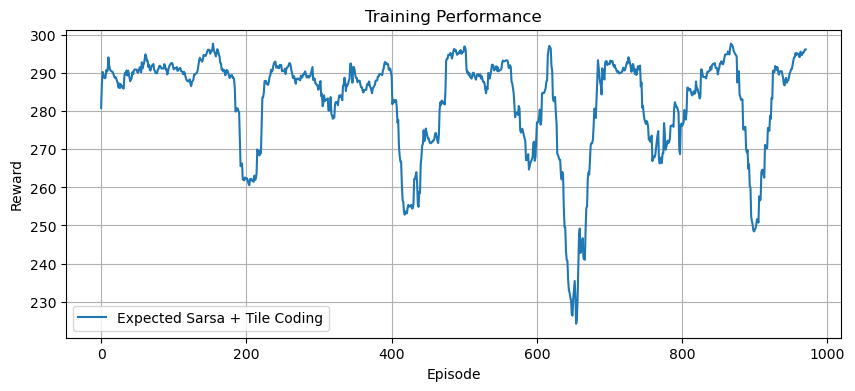

In [19]:
def smooth(y, box=30):
    box = min(box, len(y))
    return np.convolve(y, np.ones(box)/box, mode='valid')

plt.figure(figsize=(10, 4))
plt.plot(smooth(rewards, box=30), label='Expected Sarsa + Tile Coding')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Performance")
plt.grid(True)
plt.legend()
plt.show()


In [20]:
class QLearningFAAgent:
    def __init__(self, num_actions, tile_coder, alpha=0.1, gamma=0.97, epsilon=1.0):
        self.num_actions = num_actions
        self.tc = tile_coder
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha / tile_coder.tilings
        self.w = np.zeros((num_actions, tile_coder.total_tiles))

    def get_q(self, state, action):
        features = self.tc.get_tiles(state)
        return np.sum(self.w[action][features])

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        q_vals = [self.get_q(state, a) for a in range(self.num_actions)]
        return int(np.argmax(q_vals))

    def update(self, state, action, reward, next_state, done):
        features = self.tc.get_tiles(state)
        q_sa = self.get_q(state, action)

        if done:
            target = reward
        else:
            q_next = max([self.get_q(next_state, a) for a in range(self.num_actions)])
            target = reward + self.gamma * q_next

        td_error = target - q_sa
        for f in features:
            self.w[action][f] += self.alpha * td_error


In [21]:
# Re-initialize tile coder and environment for a clean run
env2 = make_env()
tile_coder2 = TileCoder(
    low=[0.0, 0.0, 0.0], 
    high=[1.0, 1.0, 1.0], 
    bins=[10, 10, 3], 
    tilings=8
)
q_agent = QLearningFAAgent(num_actions=env2.action_space.n, tile_coder=tile_coder2)
q_learning_rewards, q_steps = train(env2, q_agent, episodes=1000)


[EP   10] Reward: 275.39 | Steps:  38 | Epsilon: 0.9511
[EP   20] Reward: 284.17 | Steps:  40 | Epsilon: 0.9046
[EP   30] Reward: 309.07 | Steps:  40 | Epsilon: 0.8604
[EP   40] Reward: 140.43 | Steps:  21 | Epsilon: 0.8183
[EP   50] Reward: 248.79 | Steps:  35 | Epsilon: 0.7783
[EP   60] Reward: 293.52 | Steps:  40 | Epsilon: 0.7403
[EP   70] Reward: 309.07 | Steps:  40 | Epsilon: 0.7041
[EP   80] Reward:  57.29 | Steps:  10 | Epsilon: 0.6696
[EP   90] Reward: 319.53 | Steps:  40 | Epsilon: 0.6369
[EP  100] Reward: 301.53 | Steps:  40 | Epsilon: 0.6058
[EP  110] Reward: 255.51 | Steps:  38 | Epsilon: 0.5762
[EP  120] Reward: 315.54 | Steps:  40 | Epsilon: 0.5480
[EP  130] Reward: 305.46 | Steps:  40 | Epsilon: 0.5212
[EP  140] Reward: 299.34 | Steps:  40 | Epsilon: 0.4957
[EP  150] Reward: 314.86 | Steps:  40 | Epsilon: 0.4715
[EP  160] Reward: 284.43 | Steps:  39 | Epsilon: 0.4484
[EP  170] Reward: 201.08 | Steps:  29 | Epsilon: 0.4265
[EP  180] Reward: 259.69 | Steps:  38 | Epsilon:

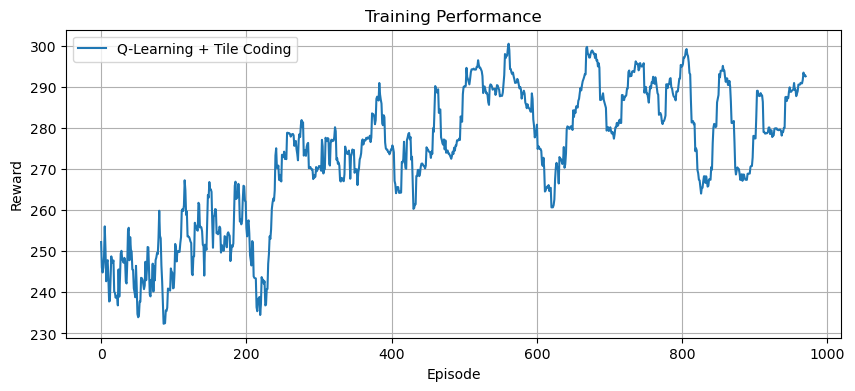

In [22]:
def smooth(y, box=10):
    box = min(box, len(y))
    return np.convolve(y, np.ones(box)/box, mode='valid')

plt.figure(figsize=(10, 4))
plt.plot(smooth(q_learning_rewards, box=30), label='Q-Learning + Tile Coding')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Performance")
plt.grid(True)
plt.legend()
plt.show()


In [23]:

results = {
    "Expected SARSA": {"rewards": rewards},
    "Q-learning": {"rewards": q_learning_rewards},
}

last_n = 100

print(f"{'Method':<25} | {'Avg Reward':<10} | {'Std Dev':<10} | {'Final Reward':<10}")
print("-" * 65)


for method, data in results.items():
    rewards_c = np.array(data['rewards'])
    if len(rewards_c) < last_n:
        avg_reward = rewards_c.mean()
        std_reward = rewards_c.std()
        final_reward = rewards_c[-1]
    else:
        avg_reward = rewards_c[-last_n:].mean()
        std_reward = rewards_c[-last_n:].std()
        final_reward = rewards_c[-1]
    
    print(f"{method:<25} | {avg_reward:<10.2f} | {std_reward:<10.2f} | {final_reward:<10.2f}")

Method                    | Avg Reward | Std Dev    | Final Reward
-----------------------------------------------------------------
Expected SARSA            | 279.97     | 53.53      | 276.18    
Q-learning                | 283.16     | 38.32      | 295.00    
